## Annova for variance explained for the integrative PC embeddings

#### Fan Zhang

In [10]:
library(Seurat)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
library(scales)
library(pheatmap)
library(dplyr)
library(monocle)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(scales)
library(pheatmap)
library(dplyr)
library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(patchwork)
library(MASS)
library(matrixStats)
library(viridis)
library(pbapply)
library(parallel)
library(grid)

In [11]:
library(limma)
library(edgeR)
library(scater)
library(statmod)

In [5]:
suppressMessages({
                  library(data.table)
                  library(reticulate)
#                   library(Rcpp)
                  library(scales)
                  library(irlba)
                  library(singlecellmethods)
                  library(parallel)
                  library(pbapply)
                  library(patchwork)
                  library(pheatmap)
                  library(entropy)
                  library(Rtsne)
                  library(loe)
                  library(igraph)
                  library(umap)
                  library(viridis)
                 })


FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$dataset) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

plot_clusters3 <- function(cluster_ids, labels, pt_size = 14, umap_use = umap_post, do_labels = FALSE) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > 20))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>%
        subset(cluster %in% clusters_keep) 
    plt <- plt_df %>% 
        ggplot(aes(X1, X2, col = factor(cluster))) + geom_point(shape = '.', alpha = .6) + 
        theme_tufte() + geom_rangeframe(col = "black") + 
#         theme(axis.line = element_line()) +
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 21, size = 4))) + 
        scale_color_manual(values = singler.colors) +
        labs(x = "UMAP 1", y = "UMAP 2") +
        theme(plot.title = element_text(hjust = .5)) + 
        guides(col = FALSE)
    
    if (do_labels) 
        plt <- plt + geom_label(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = cluster], 
                                aes(label = cluster), size = pt_size, alpha = .8)
    return(plt)
}

Warning message:
“package ‘Rtsne’ was built under R version 3.6.3”Warning message:
“package ‘umap’ was built under R version 3.6.3”

In [13]:
meta_colors <- list(

  disease = c(

    "healthy" = "#B3B3B3",
    "mild"   = "#B2DF8A",
    "severe" = "#33A02C",
      
   
    "Healthy BALF" = "#B3B3B3",
    "Mild COVID-19"   = "#B2DF8A", 
    "Severe COVID-19" = "#33A02C",
      
    "Inflamed UC" = "#A6761D", 
    "Non-inflamed UC" = "#E6AB02", 
    "Healthy colon" = "#E5D8BD", 
    "Healthy kidney" = "#A6CEE3",
    "Healthy Lung" = "#C7EAE5", # healthy vs Pulmonary Fibrosis
    "Polymyositis lung" = "#80CDC1",
    "SS Lung" = "#003C30",
    "Systemic sclerosis lung" = "#003C30",
    "HP Lung" = "#35978F",
    "Hypersensitivity pneumonitis lung" = "#35978F",
    "Crohn" = "#FF7F00", 
    "Healthy kidney" = "#1F8888",
    "SLE kidney" = "#1F78B4",   
    "RA synovium" =  "#E31A1C", #"#6A3D9A", 
    "OA synovium"  =  "#FB9A99", # "#FB9A99", # "#CAB2D6",
      
    "MS brain" = "#6A3D9A",
    "Healthy brain" = "#CAB2D6",
      
    "Inflamed IBD" = "#A6761D", 
    "Non-inflamed IBD" = "#E6AB02", 
    "healthy (IBD)" = "#E5D8BD", 
    "Ctrl" = "#C7EAE5", # healthy vs Pulmonary Fibrosis
    "Polymyositis" = "#80CDC1",
    "Systemic sclerosis" = "#003C30",
    "Hypersensitivity pneumonitis" = "#35978F",

    "SLE" = "#1F78B4",   
    "RA" =  "#E31A1C", #"#6A3D9A", 
    "OA"  =  "black", # "#FB9A99", # "#CAB2D6",
    "MS" = "#33A02C",
    "Multiple sclerosis" = "#33A02C"
      
  ),
    
    
  "dataset" = c(    
    "AMP SLE Phase 1 Celseq" = "#006837",
    "AMP SLE Phase 1 Fluidigm" = "#ADDD8E",
    "RA" = "#6A3D9A", # "#E31A1C",  
    "AMP RA" = "#6A3D9A", # "#E31A1C",  
    "AMP RA Phase 1" = "#E31A1C",
    "Rahul" = "#FC8D62",
    "Crohn (Venema)" = "#FF7F00", 
    "UC (Smillie)" = "#A6761D",
    "Lung disease (Reyfman)" = "#7570B3",
    "AMP SLE" = "#1F78B4", 
    "RA" = "#E31A1C",
    "MS (Jäkel)" = "#33A02C",
    "MS (Schirmer)" = "#33A02C"
      
  ),
      cluster = c(
      "0" = "#E41A1C", 
      "1" = "#FF7F00", 
      "2" =  "#FFFF33", 
      "3" =  "#984EA3", 
      "4" =  "#377EB8",
      "5" =   "#4DAF4A", 
      "6" =  "#A65628",
      "7" = "#F781BF"
  )

)

## Load data

In [16]:
meta_all <- readRDS("meta_all_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung_pca_harmony_umap_cluster_new_new_new_2020-05-26.rds")
meta_all[1:4,]

cell,dataset,technology,sample,disease,cell_type,nUMI,nGene,percent_mito,percent.ribo,...,harmonized_UMAP2,res_0.40,res_0.60,res_0.80,tissue,disease_new,broad_cell_type,broad_cell_type_nk,gene,broad_cell_type_nk_dc
S006_L1Q1_A03,AMP RA,Celseq,301-0159,OA,SC-T1,2099,1145,0,0.14006670,...,7.381156,0,0,0,Synovium,RA synovium,T cells,T cells,0.000000,T cells
S006_L1Q1_A05,AMP RA,Celseq,301-0159,OA,SC-T4,3110,1559,0,0.07073955,...,6.361036,0,2,1,Synovium,RA synovium,T cells,T cells,0.000000,T cells
S006_L1Q1_A07,AMP RA,Celseq,301-0159,OA,SC-T1,1966,1204,0,0.04933876,...,9.875762,0,0,0,Synovium,RA synovium,T cells,T cells,0.000000,T cells
S006_L1Q1_A09,AMP RA,Celseq,301-0159,OA,SC-T1,2807,1464,0,0.07410046,...,6.575063,0,0,1,Synovium,RA synovium,T cells,T cells,1.517876,T cells


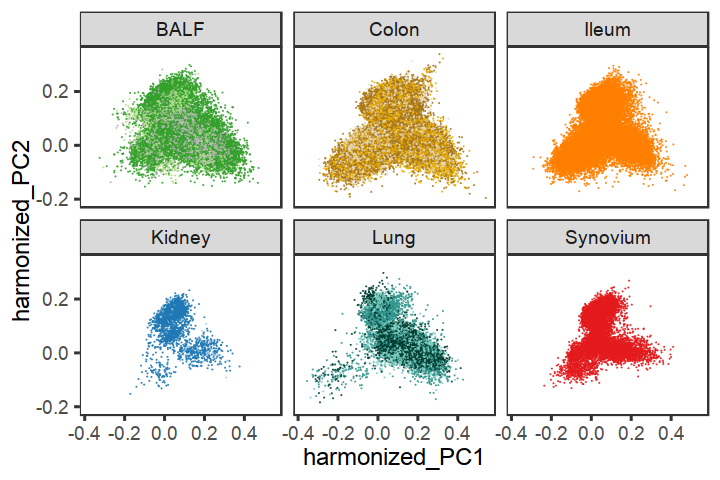

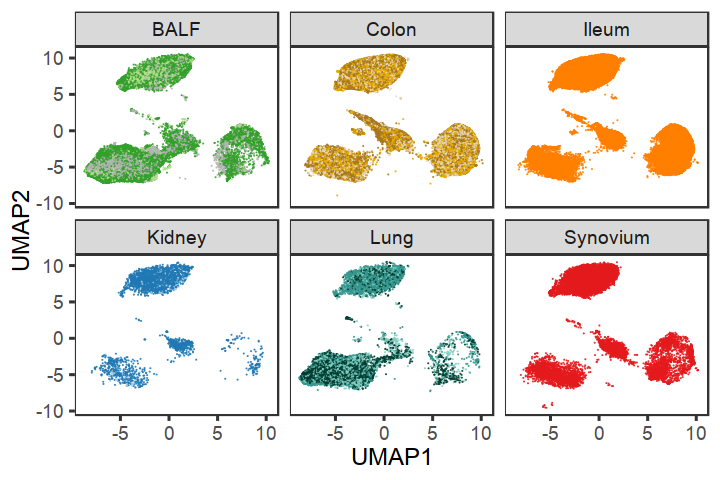

In [12]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = harmonized_PC1, y = harmonized_PC2, fill= disease_new)
      ) +
  geom_point(size = 0.3, stroke = 0.0001, shape = 21, alpha = 0.9) +
  facet_wrap( ~ tissue, ncol = 3) +
  scale_fill_manual(values = meta_colors$disease, name = "") +
  labs(
      x = "harmonized_PC1",
      y = "harmonized_PC2"
      ) +
  theme_bw(base_size = 14) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("harmonized_pc", ".png", sep = ""), width = 6, height = 4, dpi = 500)



ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= disease_new)
      ) +
  geom_point(size = 0.3, stroke = 0.0001, shape = 21, alpha = 0.9) +
  facet_wrap( ~ tissue, ncol = 3) +
  scale_fill_manual(values = meta_colors$disease, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 14) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("harmonized_UMAP", ".png", sep = ""), width = 6, height = 4, dpi = 500)

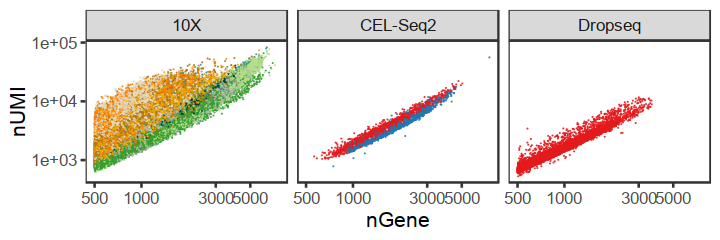

In [20]:
meta_all[which(meta_all$technology == "Celseq"),]$technology <- "CEL-Seq2"
meta_all$technology <- factor(meta_all$technology, levels = c("10X", "CEL-Seq2", "Dropseq"))

options(repr.plot.height = 2, repr.plot.width = 6)
ggplot(meta_all[sample(nrow(meta_all)),],
       aes(x = nGene, y = nUMI, fill= disease_new)
      ) +
  geom_point(size = 0.3, stroke = 0.0001, shape = 21, alpha = 0.9) +
  scale_x_log10() +
  scale_y_log10() +
  facet_wrap( ~ technology, ncol = 4) +
  scale_fill_manual(values = meta_colors$disease, name = "") +
#   labs(
#       x = "",
#       y = ""
#       ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("nGene_nUMI", ".png", sep = ""), width = 6, height = 2, dpi = 300)


In [57]:
dat_cov <- meta_all[, c("harmonized_PC1", "harmonized_PC2", "harmonized_PC3", "harmonized_PC4", "harmonized_PC5",
                        "harmonized_PC6", "harmonized_PC7", "harmonized_PC8", "harmonized_PC9", "harmonized_PC10",
                        "tissue", "technology", "sample", "disease", "broad_cell_type_nk_dc")]    
dat_cov[1:4,]
dim(dat_cov)

harmonized_PC1,harmonized_PC2,harmonized_PC3,harmonized_PC4,harmonized_PC5,harmonized_PC6,harmonized_PC7,harmonized_PC8,harmonized_PC9,harmonized_PC10,tissue,technology,sample,disease,broad_cell_type_nk_dc
0.003405008,0.1269789,0.04046386,-0.06715000,-0.05444816,-0.03071424,-0.01142538,0.04617005,0.00343082,-0.03416376,Synovium,CEL-Seq2,301-0159,OA,T cells
0.046846953,0.1483183,0.06440890,-0.07429337,-0.01188424,-0.05395871,-0.03007850,0.01706359,0.03448158,-0.03171259,Synovium,CEL-Seq2,301-0159,OA,T cells
0.020270203,0.1212117,0.02519322,-0.06669573,-0.06717332,-0.04446077,0.05429935,0.02598387,0.01884350,-0.07356160,Synovium,CEL-Seq2,301-0159,OA,T cells
0.014654896,0.1809372,0.05866965,-0.07872286,-0.05783399,-0.02075274,-0.03421212,0.05333018,0.02142325,-0.02019788,Synovium,CEL-Seq2,301-0159,OA,T cells


[1] 308462     15

In [31]:
# Anova
fit = lm(harmonized_PC1 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_1 <- cbind(af,PctExp=afss/sum(afss)*100)
res_1$variable <- rownames(res_1)
res_1$variable[which(res_1$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_1)

res_1$variable[which(res_1$variable == "Residuals")] <- "Other"
res_1$variable[which(res_1$variable == "technology")] <- "Technology"
res_1$variable[which(res_1$variable == "tissue")] <- "Tissue"
res_1$variable[which(res_1$variable == "sample")] <- "Sample"

                          Df       Sum Sq      Mean Sq      F value    Pr(>F)
broad_cell_type_nk_dc      8 1.724518e+03 2.155647e+02 59340.503568 0.0000000
tissue                     5 3.026900e+01 6.053800e+00  1666.485606 0.0000000
technology                 2 1.195626e-02 5.978129e-03     1.645655 0.1928879
sample                   120 1.000253e+01 8.335445e-02    22.945753 0.0000000
Residuals             308326 1.120048e+03 3.632675e-03           NA        NA
                           PctExp        variable
broad_cell_type_nk_dc 59.77843755 Broad cell type
tissue                 1.04924019          tissue
technology             0.00041445      technology
sample                 0.34672639          sample
Residuals             38.82518143       Residuals


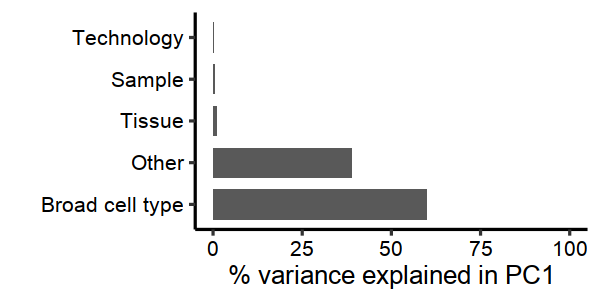

In [32]:
options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_1, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC1") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc1", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


In [33]:
# Anova
fit = lm(harmonized_PC2 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_2 <- cbind(af,PctExp=afss/sum(afss)*100)
res_2$variable <- rownames(res_2)
res_2$variable[which(res_2$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_2)

res_2$variable[which(res_2$variable == "Residuals")] <- "Other"
res_2$variable[which(res_2$variable == "technology")] <- "Technology"
res_2$variable[which(res_2$variable == "tissue")] <- "Tissue"
res_2$variable[which(res_2$variable == "sample")] <- "Sample"

                          Df       Sum Sq      Mean Sq      F value
broad_cell_type_nk_dc      8 1457.8895830 1.822362e+02 181943.09408
tissue                     5    4.5157861 9.031572e-01    901.70461
technology                 2    0.1189601 5.948006e-02     59.38440
sample                   120    3.2955636 2.746303e-02     27.41886
Residuals             308326  308.8227021 1.001611e-03           NA
                            Pr(>F)       PctExp        variable
broad_cell_type_nk_dc 0.000000e+00 82.151165938 Broad cell type
tissue                0.000000e+00  0.254461722          tissue
technology            1.639271e-26  0.006703329      technology
sample                0.000000e+00  0.185702947          sample
Residuals                       NA 17.401966064       Residuals


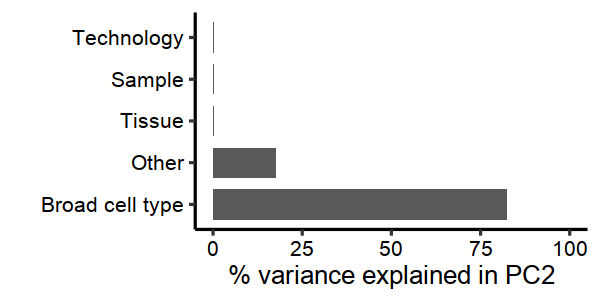

In [34]:
options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_2, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC2") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc2", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


In [52]:
# Anova
fit = lm(harmonized_PC3 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_3 <- cbind(af,PctExp=afss/sum(afss)*100)
res_3$variable <- rownames(res_3)
res_3$variable[which(res_3$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_3)

res_3$variable[which(res_3$variable == "Residuals")] <- "Other"
res_3$variable[which(res_3$variable == "technology")] <- "Technology"
res_3$variable[which(res_3$variable == "tissue")] <- "Tissue"
res_3$variable[which(res_3$variable == "sample")] <- "Sample"

                          Df       Sum Sq     Mean Sq     F value        Pr(>F)
broad_cell_type_nk_dc      8  44.20110841 5.525138551 4348.021352  0.000000e+00
tissue                     5   0.13395748 0.026791495   21.083633  3.836390e-21
technology                 2   0.05987335 0.029936675   23.558740  5.879644e-11
sample                   120   1.42490891 0.011874241    9.344463 8.680472e-162
Residuals             308326 391.79749386 0.001270725          NA            NA
                           PctExp        variable
broad_cell_type_nk_dc 10.10040146 Broad cell type
tissue                 0.03061064          tissue
technology             0.01368167      technology
sample                 0.32560613          sample
Residuals             89.52970010       Residuals


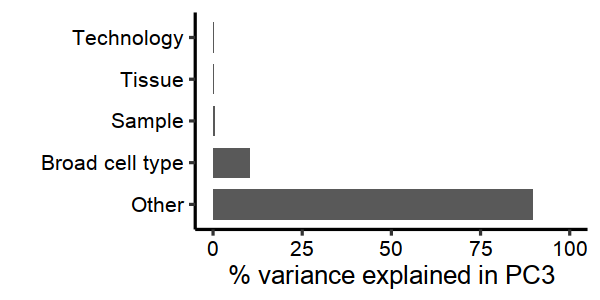

In [53]:
options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_3, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC3") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc3", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


In [45]:
# Anova
fit = lm(harmonized_PC4 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_4 <- cbind(af,PctExp=afss/sum(afss)*100)
res_4$variable <- rownames(res_4)
res_4$variable[which(res_4$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_4)

res_4$variable[which(res_4$variable == "Residuals")] <- "Other"
res_4$variable[which(res_4$variable == "technology")] <- "Technology"
res_4$variable[which(res_4$variable == "tissue")] <- "Tissue"
res_4$variable[which(res_4$variable == "sample")] <- "Sample"

                          Df      Sum Sq      Mean Sq     F value       Pr(>F)
broad_cell_type_nk_dc      8 260.3451909 32.543148866 14371.94065 0.000000e+00
tissue                     5   0.3319231  0.066384626    29.31726 7.232145e-30
technology                 2   0.2006837  0.100341832    44.31369 5.722378e-20
sample                   120   6.7499952  0.056249960    24.84151 0.000000e+00
Residuals             308326 698.1589447  0.002264353          NA           NA
                           PctExp        variable
broad_cell_type_nk_dc 26.95679913 Broad cell type
tissue                 0.03436816          tissue
technology             0.02077929      technology
sample                 0.69891156          sample
Residuals             72.28914185       Residuals


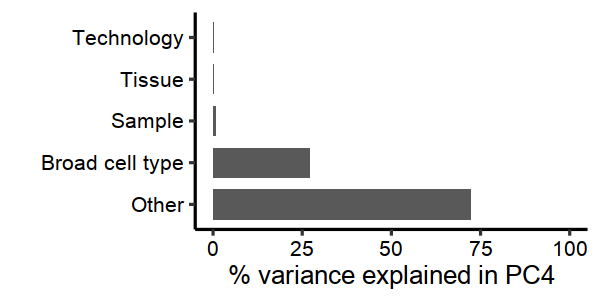

In [54]:
options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_4, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC4") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc4", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


In [43]:
# Anova
fit = lm(harmonized_PC5 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_5 <- cbind(af,PctExp=afss/sum(afss)*100)
res_5$variable <- rownames(res_5)
res_5$variable[which(res_5$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_5)

res_5$variable[which(res_5$variable == "Residuals")] <- "Other"
res_5$variable[which(res_5$variable == "technology")] <- "Technology"
res_5$variable[which(res_5$variable == "tissue")] <- "Tissue"
res_5$variable[which(res_5$variable == "sample")] <- "Sample"

                          Df       Sum Sq      Mean Sq      F value
broad_cell_type_nk_dc      8 228.09562233 28.511952792 19945.612995
tissue                     5   0.22318005  0.044636010    31.225240
technology                 2   0.02415805  0.012079023     8.449913
sample                   120   1.03535125  0.008627927     6.035690
Residuals             308326 440.74736428  0.001429485           NA
                            Pr(>F)       PctExp        variable
broad_cell_type_nk_dc 0.000000e+00 34.037738072 Broad cell type
tissue                6.748898e-32  0.033304208          tissue
technology            2.139686e-04  0.003605002      technology
sample                5.781577e-87  0.154501057          sample
Residuals                       NA 65.770851662       Residuals


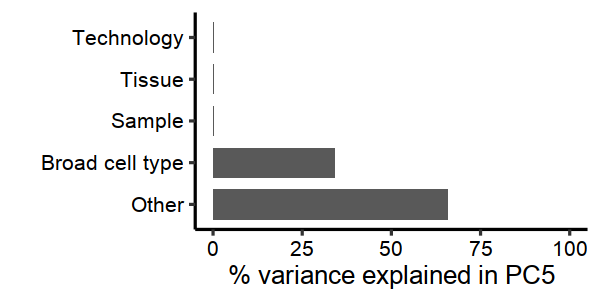

In [55]:
options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_5, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC5") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc5", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


                          Df       Sum Sq      Mean Sq      F value
broad_cell_type_nk_dc      8 604.91689867 75.614612334 117233.23187
tissue                     5   2.53003239  0.506006479    784.51470
technology                 2   0.04132841  0.020664204     32.03787
sample                   120   2.24583116  0.018715260     29.01622
Residuals             308326 198.86810754  0.000644993           NA
                            Pr(>F)       PctExp        variable
broad_cell_type_nk_dc 0.000000e+00 74.810197157 Broad cell type
tissue                0.000000e+00  0.312889626          tissue
technology            1.223415e-14  0.005111093      technology
sample                0.000000e+00  0.277742401          sample
Residuals                       NA 24.594059723       Residuals
                          Df      Sum Sq      Mean Sq     F value       Pr(>F)
broad_cell_type_nk_dc      8 191.4479957 23.930999467 21731.70264 0.000000e+00
tissue                     5   3.2934181  0.658683

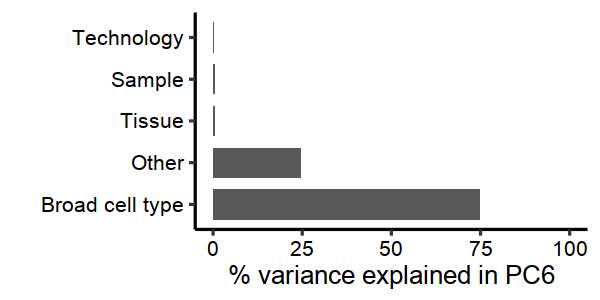

                          Df       Sum Sq      Mean Sq     F value
broad_cell_type_nk_dc      8  98.82535808 1.235317e+01 13982.03048
tissue                     5   1.15586807 2.311736e-01   261.65564
technology                 2   0.01043184 5.215920e-03     5.90368
sample                   120   1.22465301 1.020544e-02    11.55111
Residuals             308326 272.40703157 8.835033e-04          NA
                             Pr(>F)       PctExp        variable
broad_cell_type_nk_dc  0.000000e+00 26.450531007 Broad cell type
tissue                4.075018e-280  0.309367200          tissue
technology             2.729691e-03  0.002792074      technology
sample                1.180161e-213  0.327777434          sample
Residuals                        NA 72.909532284       Residuals


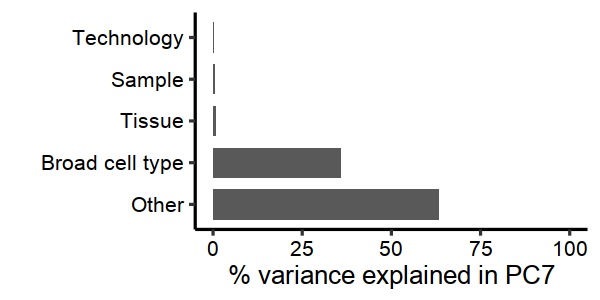

                          Df       Sum Sq      Mean Sq      F value
broad_cell_type_nk_dc      8 8.243615e+01 1.030452e+01 18362.171019
tissue                     5 6.937487e-02 1.387497e-02    24.724556
technology                 2 2.817033e-03 1.408517e-03     2.509911
sample                   120 1.006997e+00 8.391644e-03    14.953518
Residuals             308326 1.730270e+02 5.611819e-04           NA
                             Pr(>F)       PctExp        variable
broad_cell_type_nk_dc  0.000000e+00 32.133547934 Broad cell type
tissue                 5.423025e-25  0.027042271          tissue
technology             8.127716e-02  0.001098077      technology
sample                2.755642e-295  0.392526781          sample
Residuals                        NA 67.445784937       Residuals


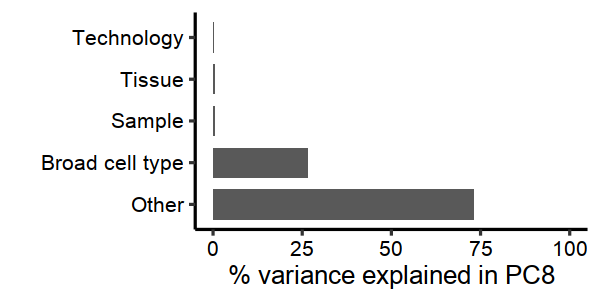

                          Df       Sum Sq     Mean Sq      F value
broad_cell_type_nk_dc      8 6.924291e+01 8.655363640 10380.224501
tissue                     5 1.088377e+00 0.217675319   261.054160
technology                 2 2.098466e-03 0.001049233     1.258326
sample                   120 1.154775e+00 0.009623122    11.540840
Residuals             308326 2.570921e+02 0.000833832           NA
                             Pr(>F)       PctExp        variable
broad_cell_type_nk_dc  0.000000e+00 2.107336e+01 Broad cell type
tissue                1.815226e-279 3.312362e-01          tissue
technology             2.841306e-01 6.386463e-04      technology
sample                2.068537e-213 3.514437e-01          sample
Residuals                        NA 7.824332e+01       Residuals


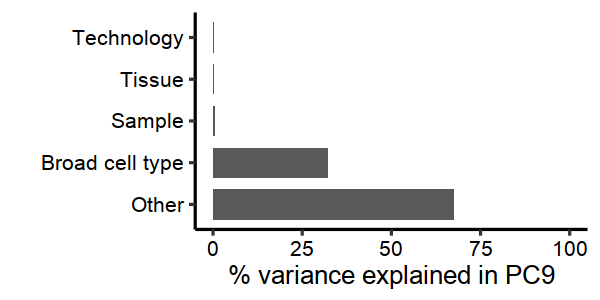

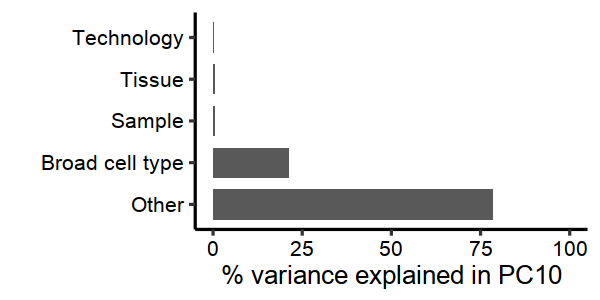

In [65]:
# Anova
fit = lm(harmonized_PC6 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_6 <- cbind(af,PctExp=afss/sum(afss)*100)
res_6$variable <- rownames(res_6)
res_6$variable[which(res_6$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_6)

res_6$variable[which(res_6$variable == "Residuals")] <- "Other"
res_6$variable[which(res_6$variable == "technology")] <- "Technology"
res_6$variable[which(res_6$variable == "tissue")] <- "Tissue"
res_6$variable[which(res_6$variable == "sample")] <- "Sample"


options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_6, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC6") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc6", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)




# Anova
fit = lm(harmonized_PC7 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_7 <- cbind(af,PctExp=afss/sum(afss)*100)
res_7$variable <- rownames(res_7)
res_7$variable[which(res_7$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_7)

res_7$variable[which(res_7$variable == "Residuals")] <- "Other"
res_7$variable[which(res_7$variable == "technology")] <- "Technology"
res_7$variable[which(res_7$variable == "tissue")] <- "Tissue"
res_7$variable[which(res_7$variable == "sample")] <- "Sample"

options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_7, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC7") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc7", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)




# Anova
fit = lm(harmonized_PC8 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_8 <- cbind(af,PctExp=afss/sum(afss)*100)
res_8$variable <- rownames(res_8)
res_8$variable[which(res_8$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_8)

res_8$variable[which(res_8$variable == "Residuals")] <- "Other"
res_8$variable[which(res_8$variable == "technology")] <- "Technology"
res_8$variable[which(res_8$variable == "tissue")] <- "Tissue"
res_8$variable[which(res_8$variable == "sample")] <- "Sample"

options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_8, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC8") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc8", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)




# Anova
fit = lm(harmonized_PC9 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_9 <- cbind(af,PctExp=afss/sum(afss)*100)
res_9$variable <- rownames(res_9)
res_9$variable[which(res_9$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_9)

res_9$variable[which(res_9$variable == "Residuals")] <- "Other"
res_9$variable[which(res_9$variable == "technology")] <- "Technology"
res_9$variable[which(res_9$variable == "tissue")] <- "Tissue"
res_9$variable[which(res_9$variable == "sample")] <- "Sample"

options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_9, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC9") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc9", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)




# Anova
fit = lm(harmonized_PC10 ~ broad_cell_type_nk_dc + tissue + technology + sample, data = dat_cov)
# summary(fit)

af <- anova(fit)
afss <- af$"Sum Sq"

res_10 <- cbind(af,PctExp=afss/sum(afss)*100)
res_10$variable <- rownames(res_10)
res_10$variable[which(res_10$variable == "broad_cell_type_nk_dc")] <- "Broad cell type"
print(res_10)

res_10$variable[which(res_10$variable == "Residuals")] <- "Other"
res_10$variable[which(res_10$variable == "technology")] <- "Technology"
res_10$variable[which(res_10$variable == "tissue")] <- "Tissue"
res_10$variable[which(res_10$variable == "sample")] <- "Sample"

options(repr.plot.height = 2.5, repr.plot.width = 5)
ggplot(data=res_10, aes(x=reorder(variable, -PctExp), y=PctExp)) +
  geom_bar(stat="identity", width = 0.7) +
  coord_flip() +
  labs(x = "", y = "% variance explained in PC10") +
  scale_y_continuous(limits = c(0, 100)) +
  theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    axis.text.x = element_text(color = "black"),
    axis.text.y = element_text(color = "black"),
    panel.grid = element_blank()
  )
ggsave(file = paste("pc10", ".pdf", sep = ""), width = 5, height = 2.5, dpi = 500)


In [1]:
# celltype_var_all <- c(res_1[which(res_1$variable == "Broad cell type"),]$PctExp,
#                       res_2[which(res_2$variable == "Broad cell type"),]$PctExp,
#                       res_3[which(res_3$variable == "Broad cell type"),]$PctExp,
#                       res_4[which(res_4$variable == "Broad cell type"),]$PctExp,
#                       res_5[which(res_5$variable == "Broad cell type"),]$PctExp,
#                       res_6[which(res_6$variable == "Broad cell type"),]$PctExp,
#                       res_7[which(res_7$variable == "Broad cell type"),]$PctExp,
#                       res_8[which(res_8$variable == "Broad cell type"),]$PctExp,
#                       res_9[which(res_9$variable == "Broad cell type"),]$PctExp,
#                       res_10[which(res_10$variable == "Broad cell type"),]$PctExp
#                      )
# celltype_var_all = data.frame(
#     pc = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"),
#     pct = celltype_var_all
# )
# celltype_var_all$pc <- factor(celltype_var_all$pc, levels = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"))

# ggplot(data=celltype_var_all, 
#        aes(x=pc, y=pct)) +
#   geom_bar(stat="identity", width = 0.6) +
#   labs(x = "", y = "") +
#   scale_y_continuous(limits = c(0, 100)) +
#   theme_classic(base_size = 12) +
#   theme(
#     legend.position = "none",
# #     axis.text = element_blank(),
# #     axis.ticks = element_blank(),
#     axis.text.x = element_text(color = "black"),
#     axis.text.y = element_text(color = "black"),
#     panel.grid = element_blank()
#   )